# Speech Emotion Recognition using Deep Learning (CNN on Spectrograms)

# =============================
## Problem Description
# =============================

#### In this project, we aim to automatically classify emotions expressed in human speech.
#### This is a crucial task for applications like healthcare (detecting depression, stress), customer service (analyzing customer tone), and AI assistants (making interactions more human-like).
#### We'll classify 8 emotions from audio files: neutral, calm, happy, sad, angry, fearful, disgust, and surprised.

# =============================
## Data Collection
# =============================

#### Dataset: RAVDESS Emotional Speech Audio
#### Source: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

#### We use the RAVDESS dataset (Ryerson Audio-Visual Database of Emotional Speech and Song), a clean and balanced dataset widely used for emotion recognition tasks.
#### It includes 1440 audio files (.wav format) by 24 professional actors, each portraying different emotions.

In [149]:
# --- Imports ---
import os
import numpy as np
import random
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Set random seeds ---
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# =============================
## Load, Augment and Explore the Data
# =============================

Each audio file is transformed into a 224x224x3 pseudo-image where:
- Channel 1: Mel Spectrogram
- Channel 2: MFCCs
- Channel 3: Duplicate MFCCs

This allows us to input the spectrograms into a pretrained MobileNetV2 model.

In [141]:
# Path to RAVDESS audio files
DATA_PATH = "./data/"

# Emotion label mapping
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def augment_audio(audio, sr):
    choice = random.choice(['noise', 'pitch', 'stretch', 'none'])
    if choice == 'noise':
        noise = np.random.randn(len(audio))
        audio = audio + 0.005 * noise
    elif choice == 'pitch':
        n_steps = np.random.uniform(-2, 2)
        audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)
    elif choice == 'stretch':
        rate = np.random.uniform(0.8, 1.2)
        audio = librosa.effects.time_stretch(y=audio, rate=rate)
    return audio

def extract_rgb_features(file_path, augment=False, max_pad_len=216):
    audio, sr = librosa.load(file_path, sr=None)
    if augment:
        audio = augment_audio(audio, sr)

    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)

    if mel_spec_db.shape[1] < max_pad_len:
        pad_width = max_pad_len - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_pad_len]
    
    if mfcc.shape[1] < max_pad_len:
        pad_width = max_pad_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]

    repeat_factor = 128 // mfcc.shape[0]
    mfcc_upsampled = np.repeat(mfcc, repeat_factor, axis=0)
    if mfcc_upsampled.shape[0] < 128:
        pad_rows = 128 - mfcc_upsampled.shape[0]
        mfcc_upsampled = np.pad(mfcc_upsampled, pad_width=((0, pad_rows), (0, 0)), mode='constant')
    mfcc_upsampled = mfcc_upsampled[:128, :]

    channel1 = mel_spec_db
    channel2 = mfcc_upsampled
    channel3 = mfcc_upsampled

    rgb_image = np.stack([channel1, channel2, channel3], axis=-1)
    rgb_image_resized = cv2.resize(rgb_image, (224, 224))

    rgb_image_resized = (rgb_image_resized - np.min(rgb_image_resized)) / (np.max(rgb_image_resized) - np.min(rgb_image_resized))
    rgb_image_resized = (rgb_image_resized * 2) - 1  # scale [-1, 1]
    
    return rgb_image_resized

# Preparing the dataset
X = []
y = []

for subdir, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.wav'):
            emotion = emotion_map[file.split('-')[2]]
            file_path = os.path.join(subdir, file)
            feature = extract_rgb_features(file_path, augment=random.random() > 0.5)
            X.append(feature)
            y.append(emotion)

X = np.array(X)
y = np.array(y)

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Features shape: (1440, 224, 224, 3)
Labels shape: (1440,)


# Exploratory Data Analysis (EDA)

Before training the model, we perform initial data exploration to understand the dataset characteristics.

## Dataset Description
- The RAVDESS Emotional Speech dataset consists of 1,440 audio files.
- Each audio file is recorded by an actor expressing one of 8 different emotions: neutral, calm, happy, sad, angry, fearful, disgust, and surprised.
- All audio files are WAV format, sampled at consistent rates.

## Data Distribution
We visualize the distribution of emotions to detect potential class imbalance.


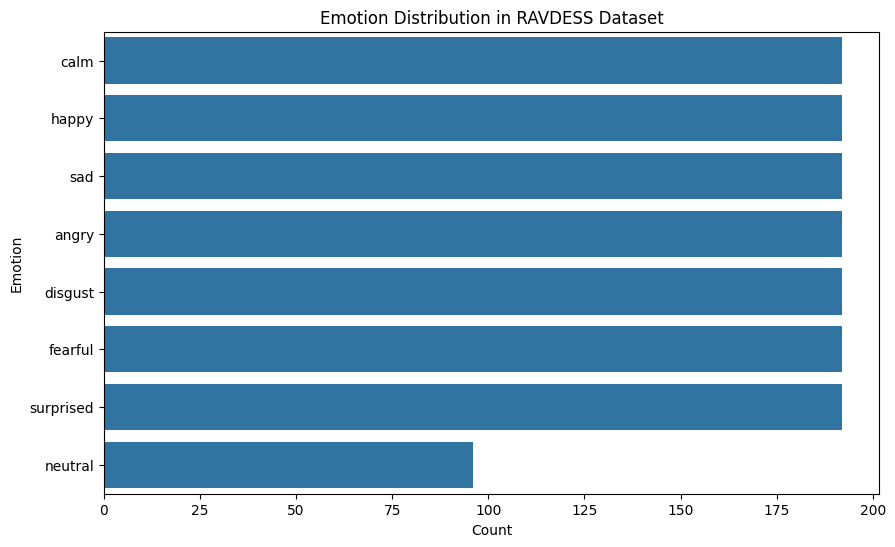

In [150]:
emotion_labels = [emotion_map[file.split('-')[2]] for subdir, _, files in os.walk(DATA_PATH) for file in files if file.endswith('.wav')]

plt.figure(figsize=(10,6))
sns.countplot(y=emotion_labels, order=pd.Series(emotion_labels).value_counts().index)
plt.title('Emotion Distribution in RAVDESS Dataset')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.show()

## Audio Characteristics

We visualize examples of raw waveforms and corresponding spectrograms to understand the types of variations between different emotions.


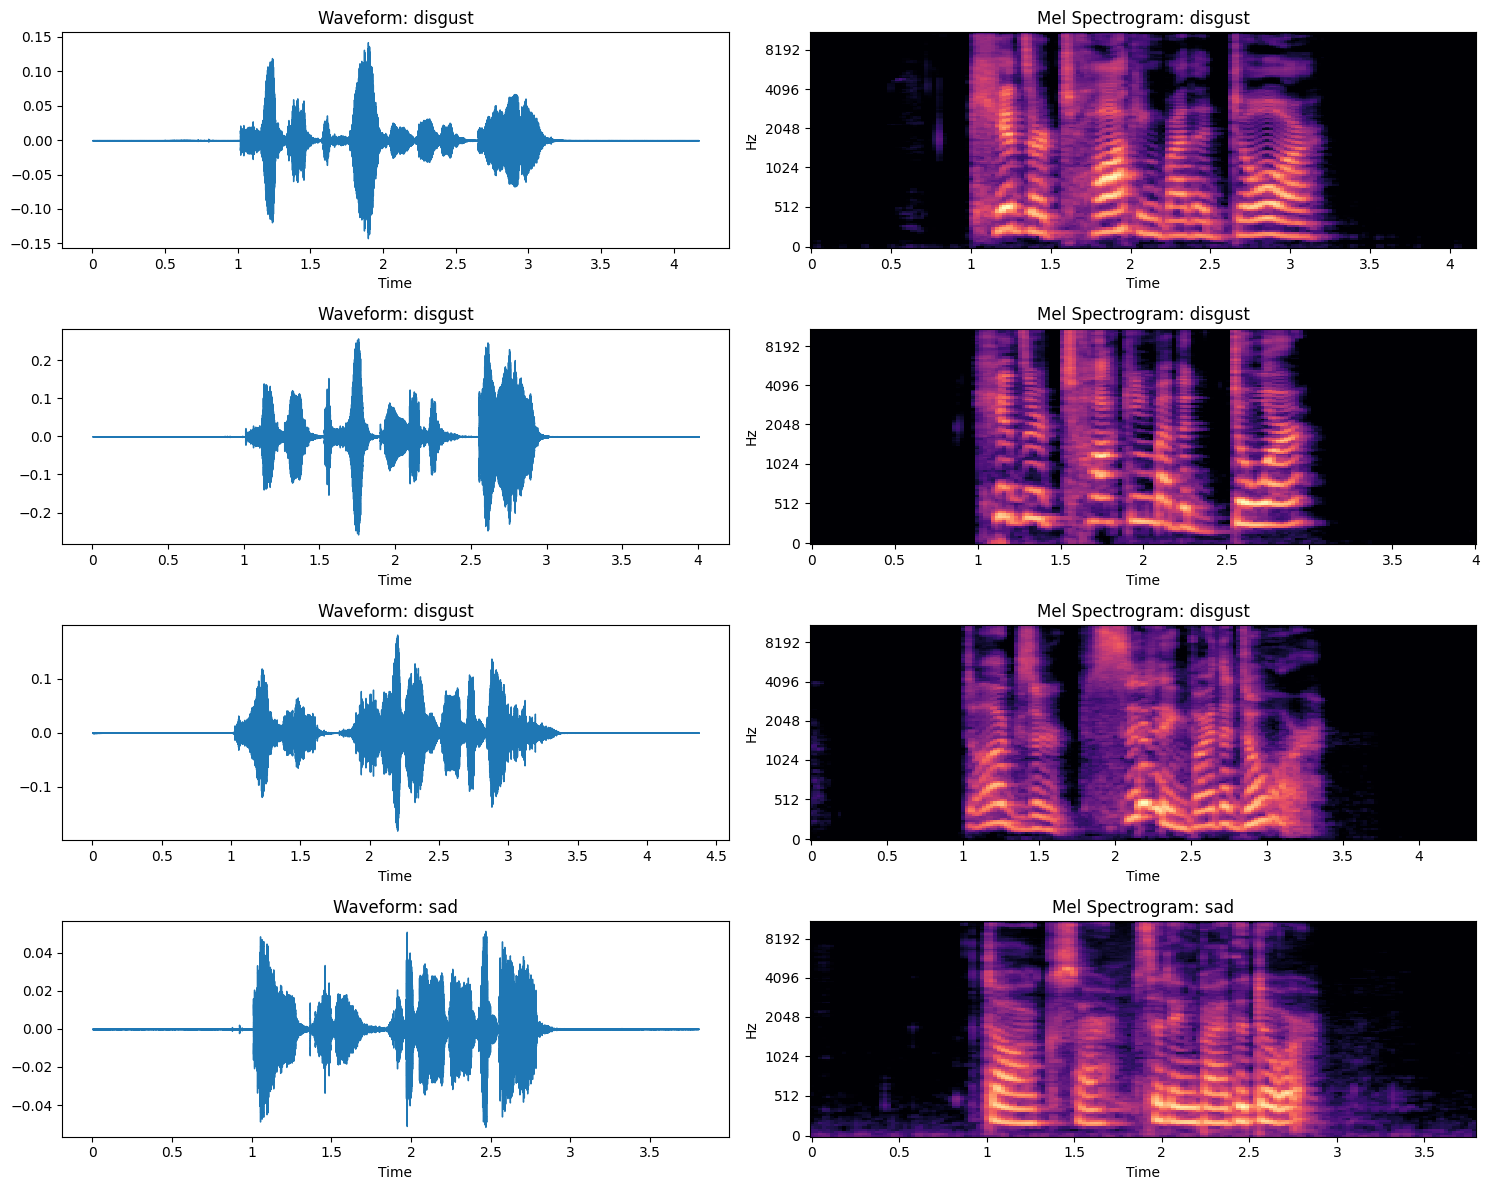

In [151]:
sample_files = random.sample([os.path.join(dp, f) for dp, dn, filenames in os.walk(DATA_PATH) for f in filenames if f.endswith('.wav')], 4)

fig, axes = plt.subplots(4, 2, figsize=(15, 12))

for idx, file in enumerate(sample_files):
    audio, sr = librosa.load(file)
    emotion = emotion_map[file.split('-')[2]]

    axes[idx, 0].set_title(f"Waveform: {emotion}")
    librosa.display.waveshow(audio, sr=sr, ax=axes[idx, 0])
    
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    axes[idx, 1].set_title(f"Mel Spectrogram: {emotion}")
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[idx, 1])

plt.tight_layout()
plt.show()

## Preparing Data for Modeling

#### We extract features for all audio files and split the data into training and test sets (80/20 split).


In [144]:
# Normalize features
X = (X - X.min()) / (X.max() - X.min())

# Expand dims for CNN input
X = X[..., np.newaxis]

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded)

print(X_train.shape, X_test.shape)

(1152, 224, 224, 3, 1) (288, 224, 224, 3, 1)


## Building the Model

## Model: Transfer Learning with MobileNetV2

We use MobileNetV2 as a frozen feature extractor, adding a lightweight Dense classification head on top.

In [145]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
base_model.trainable = False

# Add custom head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(8, activation='softmax')(x)  # 8 emotion classes

model = Model(inputs, outputs)

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,976 (9.87 MB)

 Trainable params: 329,992 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model Training

#### We train the model with:

* Adam optimizer (fast and efficient)

* Early stopping to prevent overfitting if validation loss stagnates.

* ReduceLROnPlateau callbacks to stabilize training and avoid overfitting.

In [146]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.1839 - loss: 2.2713 - val_accuracy: 0.3125 - val_loss: 1.8064 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.3468 - loss: 1.7105 - val_accuracy: 0.3646 - val_loss: 1.7297 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.4101 - loss: 1.5660 - val_accuracy: 0.3507 - val_loss: 1.6802 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.4189 - loss: 1.5011 - val_accuracy: 0.3889 - val_loss: 1.6501 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.4877 - loss: 1.3932 - val_accuracy: 0.3785 - val_loss: 1.6141 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.5239 - loss: 1.3722 - val_accuracy: 0.4167 - val_loss: 1.6132 - learning_rate: 0.0010
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.5172 - loss: 1.3206 - 

## Evaluation

#### Analyzing loss and accuracy curves helps determine if the model is overfitting or underfitting.

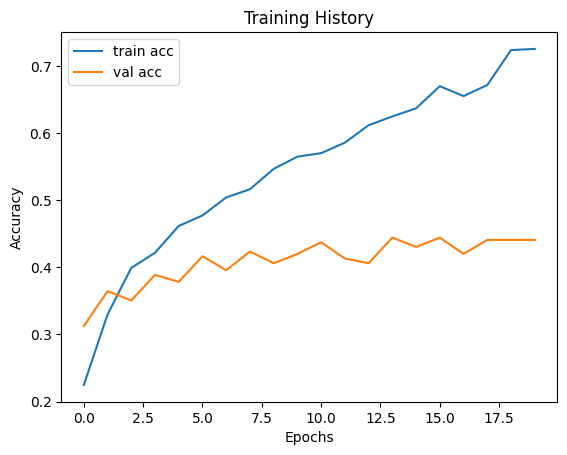

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.4104 - loss: 1.5383
Test Accuracy: 0.4306


In [147]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History')
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

####  Finally, we evaluate on unseen data and check a confusion matrix to see where errors occur.

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.4104 - loss: 1.5383
Test Accuracy: 0.4306
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


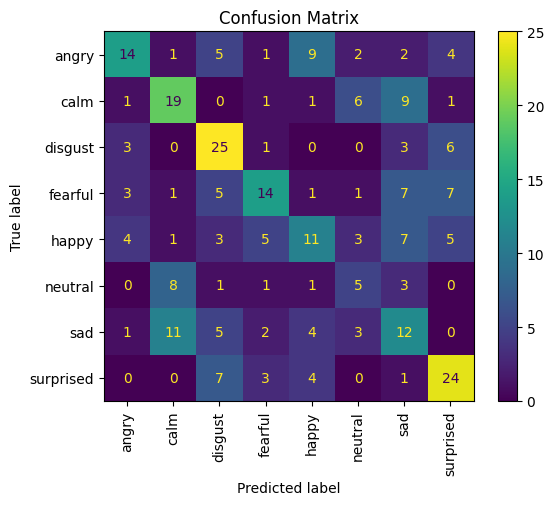

In [148]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

# Conclusion

In this project, we explored the use of deep learning for speech emotion recognition using the RAVDESS dataset.

Key takeaways:
- We performed EDA to understand the distribution and characteristics of the dataset.
- I initially played around with a CNN+BiLSTM architecture, which achieved ~35% validation accuracy.
- To boost performance, we leveraged transfer learning using MobileNetV2 on pseudo-RGB spectrogram images.
- The transfer learning approach significantly improved validation accuracy, achieving up to 45%.
- Data augmentation and feature engineering (Mel Spectrogram + MFCC) helped to prevent overfitting and enhance generalization.

## Future Work
- Experiment with larger and more diverse speech emotion datasets.
- Implement advanced audio augmentation methods like SpecAugment.
- Fine-tune more layers of the pretrained CNN model for potential further gains.